<ipython-input-2-8e76408eb029>:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x,


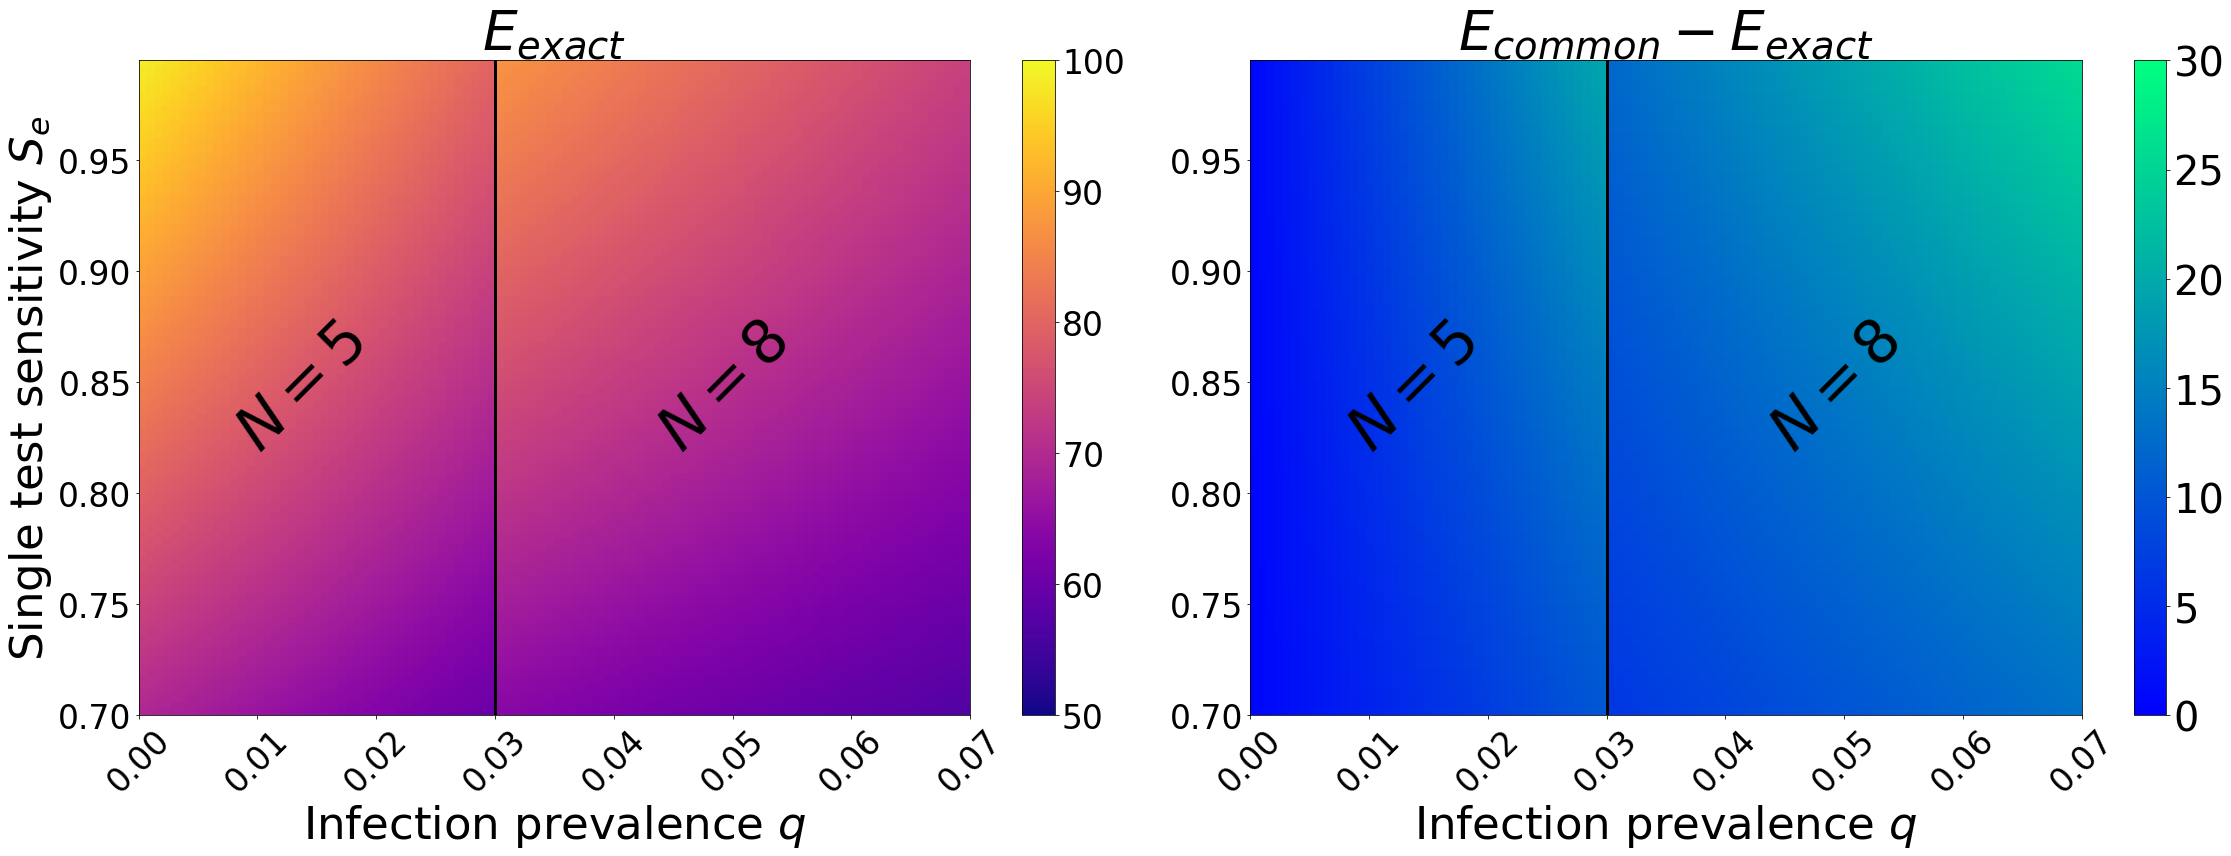

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import math


plt.rc('xtick',labelsize=33)
plt.rc('ytick',labelsize=33)


def f(tp, q, fp, model='ours', target='sfn'):
    #S = (-75*q + 9.5).astype(int)
    S = 5 + 3*(q <= 0.03)
    if model == 'our':
        if target == 'sfn':
            arr = 1 - tp*(1 - (1-tp)*(1-fp)*(1-q*tp)**(S-1))
        else:
            arr = 1 + S - S * (1-fp) * (1-q*tp)**S 
    elif model == 'common':
        if target == 'sfn':
            arr = 1 - tp**2#(1 - fn*(1-fp)*(1-q*(1-fn))**(S-1))
        else:
            arr = 1 + tp*S + S*(1-q)**S * (fp - tp)

    else:
        raise ValueError('Not implemented')
    if target == 'sfn':
        increase = (arr-(1-tp))/(1-tp) * 100
    else:
        increase = S - arr
    return increase, np.where(np.diff(S[0,:]))[0]

def make_meshes(M, N, fp, model='our', target='sfn'):
    tp = 1-np.linspace(0.005, 0.3, num=N+1, endpoint=True)
    q = np.linspace(0, 0.07 ,num=M+1, endpoint=True)
    Q, TP = np.meshgrid(q, tp)
    increase, diff = f(TP, Q, fp, model=model, target=target)
    return increase, q, tp

def plot_ax(ax,
            data,
            x,
            y,
            model,
            target,
            vmin=None, 
            vmax=None,
            cmap=None,
            tit=None,
            ylabel=True):
    im = ax.pcolormesh(x, 
                       y,
                       data,
                       cmap=cmap,
                       vmin=vmin,
                       vmax=vmax)
    
    tick_size = 40
    label_size = 45
    tit_size = 55
    
    label = 'Infection prevalence $q$'
    ax.set_xlabel(label, fontsize=label_size)

    if ylabel:
        ax.set_ylabel('Single test sensitivity $S_e$', fontsize=label_size)
    ax.set_title(tit, fontsize=tit_size)
  
    ax.text(x=0.0075, y=0.82, s="$N=5$", fontsize=60, rotation=45) 
    ax.text(x=0.043, y=0.82, s="$N=8$", fontsize=60, rotation=45)
    ax.vlines(x=0.03, color='k', ymin=min(y), ymax=max(y), linewidth=3)

    return im
    
fp = 0.01
N = 100
M = 100
ncols=2
target = 'sfn'
#target = 'efficiency'
fig, axes = plt.subplots(ncols=ncols, figsize=(ncols*16, 12))

our, q, tp = make_meshes(M, N, fp, model='our', target=target)
common, _, _ = make_meshes(M, N, fp, model='common', target=target)
diff = common - our 


ax = axes[0]
if target == 'sfn':
    vmin = 50 
    vmax = 100
    tit = "$E_{exact}$"
else:
    vmin = None
    vmax = None
    tit = '$Eff_{exact}$'
im = plot_ax(ax, 
             our,
             q,
             tp,
             model='our',
             target=target,
             vmin=vmin, 
             vmax=vmax,
             cmap='plasma',
             tit = tit) 
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=33)
ax.tick_params(axis='x', rotation=45)

ax = axes[1]
if target == 'sfn':
    tit = '$E_{common} - E_{exact}$'
    vmin = 0
    vmax = 30
else:
    vmin = None
    vmax = None
    tit = '$Eff_{common} - Eff_{exact}$'
    
im = plot_ax(ax,
             diff,
             q,
             tp,
             model='diff (common - our)',
             target=target,
             cmap='winter',
             vmin=vmin,
             vmax=vmax,
             tit=tit,
             ylabel=False)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=40)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(f'heatmap_{target}.jpg', dpi=300)
plt.show()
# plt.close()

In [3]:

tp = 0.8
fp = 0.01
N = 32
q = 0.01

def p_alone(q, N):
    return (1-q)**(N-1)

def p_not_alone(q, N):
    return 1 - p_alone(q, N)

def p_neg_given_alone(tp, fp, N):
    steps = math.log(N, 2)
    return ( (1-fp) * (1-tp) )**steps

def p_pos_given_alone(tp, fp, N):
    return 1 - p_neg_given_alone(tp, fp, N)

# p_pos_bound >= p_pos
p_pos_bound = p_alone(q, N) * p_pos_given_alone(tp, fp, N) + p_not_alone(q, N) # * p_pos_given_not_alone 

## So SFN_bound >= SFN
SFN_bound = 1 - p_pos_bound 

## So E_rel >= E_rel
E_rel_bound = (SFN_bound - (1-tp)) /(1-tp) * 100

E_rel_bound

-99.8885738851121

In [18]:
from scipy.stats import fisher_exact
arr = np.array([[24,42], [5, 57]])
tests = ('two-sided', 'less', 'greater')
for test in tests:
    print(f"Fisher exact test for {test} null:", "Statistic {:2.5f}, p-value {:.8f}".format(*fisher_exact(arr, alternative=test)))

Fisher exact test for two-sided null: Statistic 6.51429, p-value 0.00012147
Fisher exact test for less null: Statistic 6.51429, p-value 0.99998603
Fisher exact test for greater null: Statistic 6.51429, p-value 0.00010043
